In [4]:
import matplotlib.pyplot as plt
%matplotlib inline 

ModuleNotFoundError: No module named 'matplotlib'

In [5]:
import numpy as np
import pprint
pp = pprint.PrettyPrinter(indent=4)
printer = False 

ModuleNotFoundError: No module named 'numpy'

In [6]:
class Deck: #class representing deck of cards
    def __init__(self):
        self.J, self.Q, self.K, self.A = 10, 10, 10, 11
        self.cards = [2, 3, 4, 5, 6, 7, 8, 9, 10, self.J, self.Q, self.K, self.A] * 4
        self.shuffle()
        
    def shuffle(self):
        np.random.shuffle(self.cards)
        
    def reset(self): #cards for new game
        self.cards = [2, 3, 4, 5, 6, 7, 8, 9, 10, self.J, self.Q, self.K, self.A] * 4
        self.shuffle()
    
    def hit(self):
        return self.cards.pop()

In [7]:
class BlackJack: #class implementing actual blackjack game and rules
    
    def __init__(self, player): #argument is instance of class that is being played
        self.deck = Deck()
        self.player = player
        self.dealer = Dealer()
        self.wins = [] # 1 = player won, 0 is dealer, used to keep track of winrate
        self.winrate = 0 # total cumilitave winrate
        
    def play(self): 
        dealerWins = 0
        playerWins = 0
        for _ in range(10000): #plays 10,000 games
            self.dealer_draw() # dealer draws first
            self.turn(self.player)
            self.turn(self.dealer)
            winner = self.eval_winner()
            
            if winner == "dealer": #update the averages to keep track of data
                dealerWins += 1
                self.wins.append(0)
            elif winner == "player":
                playerWins += 1
                self.wins.append(1)
            
            self.deck.reset() #reset the 2 players and the deck of cards
            self.player.reset()
            self.dealer.reset()
            if printer: print(self.player.qValues)
        
        self.winrate = playerWins/(dealerWins + playerWins)
        print(self.winrate)
        if printer: pp.pprint(self.player.qValues)
        
    def dealer_draw(self): #dealer draws first
        card = self.deck.hit()
        self.dealer.receive_card(card) #give dealer his card
        self.player.receive_dealers_card(card) #let player know what card the dealer got
        if printer: print("dealer received card with value of ", card)
        
    def turn(self, player): #function representing 1 players turn
        playerMove = "hit"
        while playerMove == "hit":#give the player their card as long as they keep asking for it
            card = self.deck.hit()
            player.receive_card(card)
            val = player.hand_value()
            # if the player busts or gets blackjack, their turn is done
            if val == -1:
                # print("Busted")
                player.update()
                break
            elif val == 21:
                # print("BlackJack")
                break
            else: 
                playerMove = player.get_move()
    
    def eval_winner(self): # function to decide which player won
        playerVal = self.player.hand_value()
        dealerVal = self.dealer.hand_value()
        
        if playerVal == -1 or dealerVal > playerVal: #the dealer wins if the player busts
            return "dealer"
        elif playerVal >= dealerVal:
            # print("player won!")
            return "player"
        else:
            # print("tie")
            return "tie"

In [8]:
class Player: #this is a base class for the player, allows user to type hit or stand and actually play blackjack
    
    def __init__(self):
        self.cards = [] #keeps track of the cards in the players hand
        
    def reset(self):
        self.cards = [] #player starts with no cards
        
    def update(self): #used for q-learning updates, not used by base class
        return
        
    def receive_dealers_card(self, card):#keep track of the dealers card
        self.dealer_card = card
    
    def get_move(self): #function that game calls to get if player is standing or hitting again
        #hit or stop
        inp = ""
        while inp != "hit" and inp != "stand":
            print("Enter hit or stand: ")
            inp = input()
        return inp
    
    def receive_card(self, card): # after hitting, i add the card to my hand
        self.cards.append(card)
    
    def hand_value(self): # returns best hand value (Aces make things hard)
        # returns hard values when available ie the max possible hand value that isnt above 21
        if len(self.cards) == 0: #if i dont have any cards i dont have any value
            return 0
        value = [] # value is an array of values of the current hand
        for card in self.cards:
            if card != 11:
                if len(value) != 0:
                    for _ in range(len(value)):
                        value[_] += card
                else:
                    value = [card]
            else:
                if len(value) != 0:
                    newValue = []
                    for _ in value:
                        newValue.append(_ + 1)
                        newValue.append(_ + 11)
                    value = newValue
                else:
                    value = [1, 11]
        value = [val for val in value if val <= 21]
        if 21 in value: #if i have a blackjack i for sure want to have that be my value
            return 21
        elif len(value) == 0: #if i busted, value array wont have any possible values
            return -1
        else:
            return max(value)

In [9]:
class Dealer(Player):
    
    def get_move(self): #dealer hits if < 17
        hand = self.hand_value()
        if hand < 17:
            return "hit"
        elif hand >= 17:
            return "stand"

In [10]:
class RandomPlayer(Player): #player that randomly hits or stands (used for baseline stats)
    def get_move(self):
        return np.random.choice(["hit", "stand"])

In [14]:
# just a dictionary to set default value of state
class Counter(dict):
    def __getitem__(self, idx):
        self.setdefault(idx, idx[1])
        return dict.__getitem__(self, idx)

In [15]:
class QLearningAgent(Player): #THE MEAT
    def __init__(self):
        self.qValues = Counter() #{(dealers_card_value, players_value, player_move): q_value}
        self.lastMove = "hit" # first move is always hit
        self.lastValue = 0 # first value always 0
        self.alpha = .2 #how much i want to weigh my last observation
        super(QLearningAgent, self).__init__()
        
    def reset(self):
        self.cards = []
        self.lastMove = "hit" # reset first move to hit
        self.lastValue = 0 # reset my last value to 0 for new game, dont want to update value from last game
    
    def get_move(self): # the hard stuff
        return self.computeActionFromQValues(self.dealer_card, self.hand_value())
    
    def getQValue(self, dealerVal, playerVal, action): # dictionary lookup function
        return float(self.qValues[(dealerVal, playerVal, action)])
    
    def receive_card(self, card): # overridden because I want to update the value of my last action based on my new state
        if printer: print("card recieved")
        self.cards.append(card)
        self.update() 
    
    def computeValueFromQValues(self, dealerVal, playerVal): 
        # looks through my actions and returns the value of the highest one
        maxQVal = float("-inf")
        legalActions = self.getLegalActions(playerVal)
        if len(legalActions) == 0:
            return 0.0
        for action in legalActions:
            maxQVal = max(maxQVal, self.getQValue(dealerVal, playerVal, action))
        return maxQVal
    
    def computeActionFromQValues(self, dealerVal, playerVal):
        # function that returns my move based on observed values of my actions
        if printer: print("getting action")
        maxQVal = float("-inf")
        maxAction = None
        legalActions = self.getLegalActions(playerVal)
        for action in self.getLegalActions(playerVal):
            tempQVal = self.getQValue(dealerVal, playerVal, action)
            if tempQVal > maxQVal:
                maxQVal = tempQVal
                maxAction = action
            elif tempQVal == maxQVal:
                maxAction = np.random.choice([maxAction, action])
        if np.random.random() < .5: #random exploration
            maxAction = np.random.choice(legalActions)
        if printer: print("   ", maxAction)
        self.lastMove = maxAction
        if printer: print("    updating Last move in get action", self.lastMove)
            
        if maxAction == "stand": # if we stand, update because it wont get called again
            self.update()

        return maxAction
    
    def update(self):
        # just update value in dictionary
        # based off pacman homework
        if printer: print("Updating q val")
        # called when the player recieves a new card so values can be updated
        playerOldVal = self.lastValue
        action = self.lastMove
        playerNewVal = self.hand_value()
        
        if playerNewVal == -1: #if i busted
            playerNewVal = -4
            
        
        if printer: print("    Last Move: ", self.lastMove)
        #no discount because # of cards doesnt matter, just winning
        
        if action != "stand":
            sample = playerNewVal + self.computeValueFromQValues(self.dealer_card, playerNewVal)
            self.qValues[(self.dealer_card, playerOldVal, action)] = ((1 - self.alpha)*self.getQValue(self.dealer_card, playerOldVal, action)) + (self.alpha * sample)
        else:
            # if i stand, the value of standing in my state is just the value of my hand
            self.qValues[(self.dealer_card, playerOldVal, action)] = playerOldVal
        self.lastValue = playerNewVal
        
    def getLegalActions(self, state):
        # dumb function
        return ["hit", "stand"]

In [16]:
class TrainedQLearner(Player):
    # this is just a player that takes the qLearningAgents value dictionary and plays off of that, no more updates
    def __init__(self, qValues):
        self.qValues = qValues
        super(TrainedQLearner, self).__init__()
        
    def update(self):
        return
    
    def get_move(self):
        return self.computeActionFromQValues()
    
    def getQValue(self, dealerVal, playerVal, action):
        return float(self.qValues[(dealerVal, playerVal, action)])
        
    def computeValueFromQValues(self, dealerVal, playerVal):
        maxQVal = float("-inf")
        legalActions = ["hit", "stand"]
        for action in legalActions:
            maxQVal = max(maxQVal, self.getQValue(dealerVal, playerVal, action))
        return maxQVal
    
    def computeActionFromQValues(self):
        if printer: print("getting action")
        maxQVal = float("-inf")
        maxAction = None
        dealerVal = self.dealer_card
        playerVal = self.hand_value()
        for action in ["hit", "stand"]:
            tempQVal = self.getQValue(dealerVal, playerVal, action)
            if tempQVal > maxQVal:
                maxQVal = tempQVal
                maxAction = action
            elif tempQVal == maxQVal:
                maxAction = np.random.choice([maxAction, action])
        if printer: print("   ", maxAction)
        self.lastMove = maxAction
        if printer: print("    updating Last move in get action", self.lastMove)

        return maxAction
    
    def getLegalActions(self, state):
        return ["hit", "stand"]

In [18]:
#make pretty graphs
def graph_it(wins, winrate, x, y, title):
    sums = []
    for i in range(1, len(wins)):
        sums.append(sum(wins[0:i])/i)
    plt.plot(sums)
    plt.plot([winrate for _ in range(1, len(wins))], 'y-', alpha= .75)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.show()

0.391


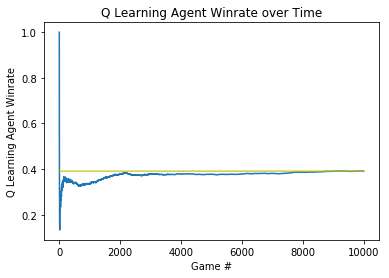

0.4993


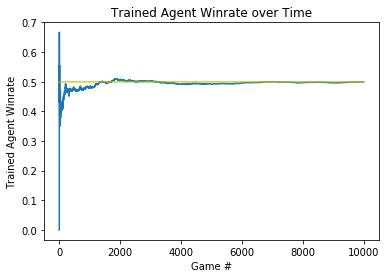

0.326


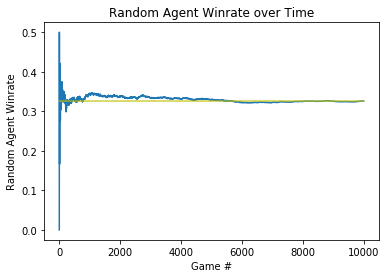

In [19]:
# how to play the actual game
game = BlackJack(QLearningAgent())
game.play()
graph_it(game.wins, game.winrate, "Game #", "Q Learning Agent Winrate", "Q Learning Agent Winrate over Time")
array = game.player.qValues
game = BlackJack(TrainedQLearner(array))
game.play()
graph_it(game.wins, game.winrate, "Game #", "Trained Agent Winrate", "Trained Agent Winrate over Time")
game = BlackJack(RandomPlayer())
game.play()
graph_it(game.wins, game.winrate, "Game #", "Random Agent Winrate", "Random Agent Winrate over Time")
# pp.pprint(array)